1. Выполните поиск ассоциативных правил для наборов данных из задания по поиску частых наборов. Зафиксируйте значение пороговое значение поддержки (например, 10%), варьируйте пороговое значение достоверности (например, от 70% до 95% с шагом 5%). 
- Получите список результирующих правил в удобочитаемом виде (антецедент==>консеквент). 
- Отфильтруйте правила, в которых антецедент и консеквент суммарно включают в себя не более семи объектов.
- Проанализируйте и изложите содержательный смысл полученного результата.
2. Выполните визуализацию полученных результатов в виде следующих диаграмм:
- сравнение быстродействия поиска правил на фиксированном наборе данных при изменяемом пороге достоверности; 
- общее количество найденных правил на фиксированном наборе данных при изменяемом пороге достоверности; 
- максимальное количество объектов в правиле на фиксированном наборе данных при изменяемом пороге достоверности; 
- количество правил, в которых антецедент и консеквент суммарно включают в себя не более семи объектов, на фиксированном наборе данных при изменяемом пороге достоверности.
3. Подготовьте отчет о выполнении задания и загрузите его в систему.

In [1]:
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder

data3 = pd.read_csv("UCI_dataset_norm.csv", header = 0, index_col = 0).reset_index()

print(data3.shape)

data3 = data3.bfill(axis=1).ffill(axis=1)
data3 = data3.applymap(int)
data3 = data3.applymap(str)
l_data3 = data3.values.tolist()

#te for mlxtend
te = TransactionEncoder()

te_ary = te.fit(l_data3).transform(l_data3)
te_data3 = pd.DataFrame(te_ary, columns=te.columns_)

(25899, 20)


In [2]:
#Функции, для которых будем вычислять время выполнения
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
min_support = 0.0075
confidences = np.linspace(0.0, 0.7, 15)

recruitments = apriori(te_data3, min_support=min_support, max_len=7, use_colnames=True)

def ass_rules_execute(recruitments, confidence):
    return association_rules(recruitments, metric="confidence", min_threshold=confidence)

for confidence in confidences:
    rules = ass_rules_execute(recruitments, confidence)
    print(f"min_confidence = {confidence}")
    print(rules)

min_confidence = 0.0
    antecedents consequents  antecedent support  consequent support   support  \
0           (1)        (24)            0.057917            0.025291  0.010927   
1          (24)         (1)            0.025291            0.057917  0.010927   
2          (38)         (1)            0.021893            0.057917  0.009537   
3           (1)        (38)            0.057917            0.021893  0.009537   
4          (73)         (1)            0.017375            0.057917  0.007838   
..          ...         ...                 ...                 ...       ...   
123    (38, 24)        (73)            0.015599            0.017375  0.010618   
124    (73, 24)        (38)            0.012356            0.021893  0.010618   
125        (38)    (73, 24)            0.021893            0.012356  0.010618   
126        (73)    (38, 24)            0.017375            0.015599  0.010618   
127        (24)    (73, 38)            0.025291            0.013128  0.010618   

     c

min_confidence = 0.44999999999999996
   antecedents consequents  antecedent support  consequent support   support  \
0         (73)         (1)            0.017375            0.057917  0.007838   
1        (102)        (76)            0.014479            0.017414  0.008726   
2         (76)       (102)            0.017414            0.014479  0.008726   
3         (81)       (119)            0.016449            0.013514  0.008340   
4        (119)        (81)            0.013514            0.016449  0.008340   
5        (128)        (26)            0.012973            0.024750  0.007993   
6        (137)        (47)            0.012780            0.021545  0.008186   
7        (190)       (148)            0.010734            0.012240  0.007838   
8        (148)       (190)            0.012240            0.010734  0.007838   
9        (148)        (45)            0.012240            0.021700  0.007606   
10       (175)       (152)            0.011159            0.012201  0.007954   
11 

сравнение быстродействия поиска правил на фиксированном наборе данных при изменяемом пороге достоверности;

In [3]:
import sys
import shutil, os 
from timeit import Timer
pd.options.display.expand_frame_repr = False
from collections import OrderedDict
         
loops = 1000
table = []
results = []

func = ass_rules_execute

for conf in confidences:
    print(f"Рассчитывается порог достоверности: {conf*100} %")
    print("Start " + func.__name__)
    t = Timer(lambda: func(recruitments, conf))
    time = t.timeit(number = loops)
    result = func(recruitments, conf)

    #сортировка датасета по убыванию достоверности
    result.sort_values(['confidence'], ascending = False, inplace = True)

    result['len'] = result['antecedents'].apply(lambda x: len(x)) + result['consequents'].apply(lambda x: len(x))
              
    results.append(result)

    #получаем кол-во наборов различной длины
    index_series = result['len'].value_counts().index.tolist()
    count_different_len = pd.Series(index = index_series, dtype = 'Int32')
    for index in index_series:
        count_different_len[index] = result['len'].eq(index).sum() #подсчет числа вхождений

    table.append([func.__name__, conf, time, result.shape[0], result['len'].max(), count_different_len.to_dict(OrderedDict)])
pd_table = pd.DataFrame(table, columns = ['name', 'confidence', 'time', 'rows_count', 'max_len', 'count_different_len'])       
print(f"\nНабор данных UCI: сводная таблица времени выполнения")
print(pd_table)

#Вывод данных
HEAD = 3
for i, result in enumerate(results):
    print(f'Алгоритм {table[i][0]}, достоверность {table[i][1]}, количество строк результата - {result.shape[0]}')
    print(f'Первые {HEAD} строк результата c наибольшей достоверностью:')
    print(result.head(HEAD))
    print('\n')


Рассчитывается порог достоверности: 0.0 %
Start ass_rules_execute
Рассчитывается порог достоверности: 5.0 %
Start ass_rules_execute
Рассчитывается порог достоверности: 10.0 %
Start ass_rules_execute
Рассчитывается порог достоверности: 15.0 %
Start ass_rules_execute
Рассчитывается порог достоверности: 20.0 %
Start ass_rules_execute
Рассчитывается порог достоверности: 24.999999999999996 %
Start ass_rules_execute
Рассчитывается порог достоверности: 30.0 %
Start ass_rules_execute
Рассчитывается порог достоверности: 35.0 %
Start ass_rules_execute
Рассчитывается порог достоверности: 40.0 %
Start ass_rules_execute
Рассчитывается порог достоверности: 44.99999999999999 %
Start ass_rules_execute
Рассчитывается порог достоверности: 49.99999999999999 %
Start ass_rules_execute
Рассчитывается порог достоверности: 54.99999999999999 %
Start ass_rules_execute
Рассчитывается порог достоверности: 60.0 %
Start ass_rules_execute
Рассчитывается порог достоверности: 64.99999999999999 %
Start ass_rules_execut

#сравнение быстродействия поиска правил на фиксированном наборе данных при изменяемом пороге достоверности;

сравнение быстродействия ass_rules_execute на датасете UCI при изменяемом пороге поддержки
    confidence      time
0         0.00  5.247144
1         0.05  5.402812
2         0.10  5.880640
3         0.15  6.256241
4         0.20  5.359500
5         0.25  5.236558
6         0.30  5.509993
7         0.35  5.102470
8         0.40  5.046048
9         0.45  4.916446
10        0.50  5.570649
11        0.55  5.260444
12        0.60  4.810339
13        0.65  4.600535
14        0.70  4.521380


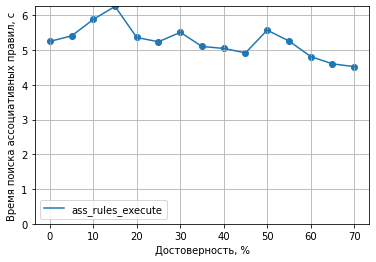

In [4]:
#сравнение быстродействия поиска ассоциативных правил на наборе данных UCI при изменяемом пороге достоверности 

import numpy as np 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

print(f"сравнение быстродействия {pd_table['name'].iloc[0]} на датасете UCI при изменяемом пороге поддержки")
print(pd_table[['confidence','time']])

x = pd_table['confidence'] * 100
y = pd_table['time']
x_new = np.linspace(x.min(), x.max(),500)

f = interp1d(x, y, kind='linear')
y_smooth=f(x_new)

fig, ax = plt.subplots()
ax.grid()
ax.set_xlabel('Достоверность, %')
ax.set_ylabel('Время поиска ассоциативных правил, с')
ax.set_ylim([0,y.max()])

ax.plot (x_new,y_smooth, label = pd_table['name'].iloc[0])
ax.scatter (x, y) 
ax.legend()
plt.show()

общее количество найденных правил на фиксированном наборе данных при изменяемом пороге достоверности;

общее количество правил на датасете UCI при изменяемом пороге поддержки
    confidence  rows_count
0         0.00         128
1         0.05         128
2         0.10         128
3         0.15         127
4         0.20         118
5         0.25         108
6         0.30          97
7         0.35          76
8         0.40          54
9         0.45          40
10        0.50          32
11        0.55          23
12        0.60          20
13        0.65           9
14        0.70           7


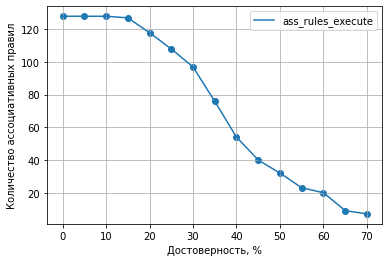

In [5]:
#общее количество правил на фиксированном наборе данных при изменяемом пороге поддержки; 

print(f"общее количество правил на датасете UCI при изменяемом пороге поддержки")
print(pd_table[['confidence','rows_count']])

x = pd_table['confidence'] * 100
y = pd_table['rows_count']
x_new = np.linspace(x.min(), x.max(),500)

f = interp1d(x, y, kind='linear')
y_smooth=f(x_new)

fig, ax = plt.subplots()
ax.grid()
ax.set_xlabel('Достоверность, %')
ax.set_ylabel('Количество ассоциативных правил')
#ax.set_ylim([0,y.max()])

ax.plot (x_new,y_smooth, label = pd_table['name'].iloc[0])
ax.scatter (x, y) 
ax.legend()
plt.show()

максимальное количество объектов в правиле на датасете UCI при изменяемом пороге поддержки
    confidence  max_len
0         0.00        3
1         0.05        3
2         0.10        3
3         0.15        3
4         0.20        3
5         0.25        3
6         0.30        3
7         0.35        3
8         0.40        3
9         0.45        3
10        0.50        3
11        0.55        3
12        0.60        3
13        0.65        3
14        0.70        3


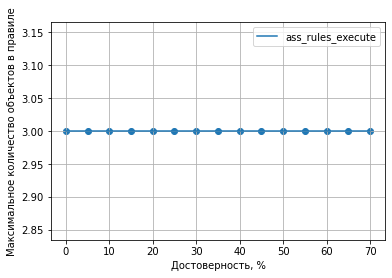

In [6]:
#максимальное количество объектов в правиле на фиксированном наборе данных при изменяемом пороге достоверности; 

print(f"максимальное количество объектов в правиле на датасете UCI при изменяемом пороге поддержки")
print(pd_table[['confidence','max_len']])

x = pd_table['confidence'] * 100
y = pd_table['max_len']
x_new = np.linspace(x.min(), x.max(),500)

f = interp1d(x, y, kind='linear')
y_smooth=f(x_new)

fig, ax = plt.subplots()
ax.grid()
ax.set_xlabel('Достоверность, %')
ax.set_ylabel('Максимальное количество объектов в правиле')
#ax.set_ylim([0,y.max()])

ax.plot (x_new,y_smooth, label = pd_table['name'].iloc[0])
ax.scatter (x, y) 
ax.legend()
plt.show()

количество частых наборов различной длины ass_rules_execute на датасете UCI при изменяемом пороге поддержки
0     {2: 122, 3: 6}
1     {2: 122, 3: 6}
2     {2: 122, 3: 6}
3     {2: 121, 3: 6}
4     {2: 112, 3: 6}
5     {2: 102, 3: 6}
6      {2: 91, 3: 6}
7      {2: 70, 3: 6}
8      {2: 48, 3: 6}
9      {2: 35, 3: 5}
10     {2: 28, 3: 4}
11     {2: 19, 3: 4}
12     {2: 16, 3: 4}
13      {2: 6, 3: 3}
14      {2: 5, 3: 2}
Name: count_different_len, dtype: object


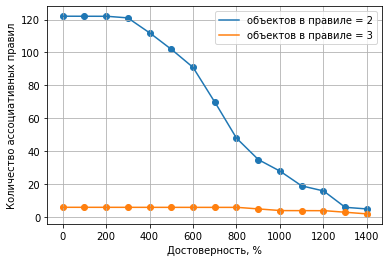

In [9]:
#количество правил, в которых антецедент и консеквент суммарно включают в себя два, три и т.д. объекта, на фиксированном наборе данных при изменяемом пороге достоверности.

print(f"количество частых наборов различной длины {pd_table['name'].iloc[0]} на датасете UCI при изменяемом пороге поддержки")
print(pd_table['count_different_len'])

x = pd_table.index * 100
x_new = np.linspace(x.min(), x.max(),500)

keys = [] #список различных длин
for d in pd_table['count_different_len']:
    for key, value in d.items():
        if key not in keys:
            keys.append(key)

#print(keys)

fig, ax = plt.subplots()
for key in keys:
    y = []
    for d in pd_table['count_different_len']:
        if (key in d.keys()) and d[key] is not None:
            y.append(d[key])
        else:
            y.append(0)

    #print(y)
    f = interp1d(x, y, kind='linear')
    y_smooth=f(x_new)

    ax.plot (x_new,y_smooth, label = 'объектов в правиле = ' + str(key))
    ax.scatter (x, y) 

ax.grid()
ax.set_xlabel('Достоверность, %')
ax.set_ylabel('Количество ассоциативных правил')
ax.legend()

plt.show()